# Result Analysis for Deephyper Graph Neural Network
### Author: Shengli Jiang (sjiang87@wisc.edu)

### Datasets: QM7, QM8, QM9, ESOL, FreeSolv, Lipophilicity

In [10]:
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

import pandas as pd

from analysis_utils import load_json, to_sec, three_random_split, three_random_mean_std, create_csv

sns.set()
sns.set_context("talk", font_scale=1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams["scatter.marker"] = 'o'
matplotlib.rcParams["lines.markersize"] = 5

### 1 Generate reward vs time figure

In [11]:
def plot_reward_vs_time(data, PLOT_DIR, ylim=None, time=True, plot=False):
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    x = times
    y = data['raw_rewards']
    plt.figure(figsize=(8.5, 6))
    if time:
        plt.plot(x, y, 'o', markersize=3)
        plt.xlabel('Time (sec)')
    else:
        plt.plot(y, 'o', markersize=3)
        plt.xlabel('Iterations')
    plt.ylabel('Reward (-MAE)')
    
    plt.xlim(left=0)
    if ylim is not None:
        plt.ylim(ylim)
    plt.locator_params(axis='y', nbins=6)
    plt.savefig(PLOT_DIR+'reward.png', dpi=300)
    if not plot:
        plt.close();

### 2.3 Three random split data parity plot

In [12]:
def three_random_parity_plot(DATA_DIR, PLOT_DIR, multi_class=False, limits=None, plot=False):
    _, _, _, _, y_true_raw, y_pred_raw = three_random_split(DATA_DIR, multi_class=multi_class)
    if not multi_class:
        y_true = y_true_raw.ravel()
        y_pred = y_pred_raw.ravel()
        plt.figure(figsize=(8,6))
        min_value = np.min([y_true.min(), y_pred.min()])
        max_value = np.max([y_true.max(), y_pred.max()])
        dist = max_value - min_value
        min_value -= 0.03*dist
        max_value += 0.03*dist
        if limits is not None:
            min_value, max_value = limits
        plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
        plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.axis("square")
        plt.locator_params(axis='x', nbins=5)
        plt.locator_params(axis='y', nbins=5)
        plt.savefig(PLOT_DIR + "parity_plot.png")
        if not plot:
            plt.close();
    else:
        for c in range(y_true_raw.shape[-1]):
            y_true = y_true_raw[..., c].ravel()
            y_pred = y_pred_raw[..., c].ravel()
            plt.figure(figsize=(8,6))
            min_value = np.min([y_true.min(), y_pred.min()])
            max_value = np.max([y_true.max(), y_pred.max()])
            dist = max_value - min_value
            min_value -= 0.03*dist
            max_value += 0.03*dist
            if limits is not None:
                min_value, max_value = limits
            plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
            plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
            plt.xlim(min_value, max_value)
            plt.ylim(min_value, max_value)
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.axis("square")
            plt.locator_params(axis='x', nbins=5)
            plt.locator_params(axis='y', nbins=5)
            plt.savefig(PLOT_DIR + f"parity_plot_{c}.png")
            if not plot:
                plt.close();

### 3.1 CSV file to feature importance

In [13]:
def feature_importance(DATA_DIR, PLOT_DIR):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    X,y = df_new.values[:,0:-1], df_new.values[:,-1]
    X_train = X
    y_train = y
    rf = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
    rf.fit(X_train, y_train)  
    y_pred = rf.predict(X_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:] 
    features = df_new.columns 
    plt.figure(figsize=(12,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png')
    return X, y, features, rf
#     print(df.values[y.argsort()[-10:][::-1],:])

### 4.1 MoleculeNet vs Deephyeper

In [14]:
def mol_vs_deep(DATA_DIR, PLOT_DIR, mol_m, mol_s, metric='MAE', plot=False):
    m, s = three_random_mean_std(DATA_DIR=DATA_DIR)
    labels = ["Train", "Valid", "Test"]
    if metric is 'MAE':
        m = m[:3]
        s = s[:3]
    if metric is 'MSE':
        m = m[3:6]
        s = s[3:6]
    plt.figure()
    plt.barh([0.25,-1.75,-3.75], m, color="maroon", align='center', height=0.5, label="Deephyper", xerr=s, capsize=5)
    plt.barh([-0.25,-2.25,-4.25], mol_m, color="gray", align='center', height=0.5, label="MoleculeNet", xerr=mol_s, capsize=5)
    plt.yticks([0,-2,-4], labels)
    plt.xlabel(f"{metric}")
    plt.legend(loc=1)
    plt.savefig(PLOT_DIR + f"{metric}_compare.png", dpi=300)
    if not plot:
        plt.close();

# QM7

In [15]:
QM7_PLOT_DIR = r"/mnt/d/plots/anl/qm7/"
QM7_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm7/run_0721/"
QM7_data = load_json(QM7_DATA_DIR + 'data_2020-07-25_03.json')

In [17]:
plot_reward_vs_time(QM7_data, QM7_PLOT_DIR, plot=False)
three_random_parity_plot(QM7_DATA_DIR, QM7_PLOT_DIR, plot=False)
mol_vs_deep(QM7_DATA_DIR, QM7_PLOT_DIR, [67.8, 77.9, 77.9], [4.0, 10.0, 2.1], metric='MAE', plot=False)

       MAE               MSE                    R2
-----  ----------------  ---------------------  ---------------
Train  39.8414+/-0.8927  11406.9857+/-315.7167  0.7739+/-0.0063
Valid  41.5313+/-0.3054  11872.5280+/-27.8721   0.7365+/-0.0006
Test   38.4765+/-0.0840  10726.3597+/-66.6328   0.7760+/-0.0014


# QM8

In [18]:
QM8_PLOT_DIR = r"/mnt/d/plots/anl/qm8/"
QM8_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm8/run_0721/"
QM8_data = load_json(QM8_DATA_DIR + 'data_2020-07-25_14.json')

In [19]:
plot_reward_vs_time(QM8_data, QM8_PLOT_DIR, ylim=[-0.5, None], plot=False)
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, plot=False)
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, multi_class=True, plot=False)
mol_vs_deep(QM8_DATA_DIR, QM8_PLOT_DIR, [0.0128, 0.0146, 0.0143], [0.001, 0.001, 0.0011], metric='MAE', plot=False)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0091+/-0.0004  0.0005+/-0.0000  0.9600+/-0.0025
Valid  0.0122+/-0.0001  0.0008+/-0.0000  0.9360+/-0.0007
Test   0.0122+/-0.0001  0.0008+/-0.0000  0.9344+/-0.0015


In [10]:
three_random_mean_std(QM8_DATA_DIR, multi_class=True)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0052+/-0.0002  0.0001+/-0.0000  0.9708+/-0.0022
Valid  0.0068+/-0.0001  0.0001+/-0.0000  0.9468+/-0.0006
Test   0.0065+/-0.0001  0.0001+/-0.0000  0.9546+/-0.0012
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0063+/-0.0001  0.0001+/-0.0000  0.9320+/-0.0012
Valid  0.0078+/-0.0000  0.0001+/-0.0000  0.8942+/-0.0015
Test   0.0080+/-0.0001  0.0001+/-0.0000  0.8966+/-0.0010
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0103+/-0.0003  0.0008+/-0.0000  0.7244+/-0.0066
Valid  0.0129+/-0.0001  0.0011+/-0.0000  0.6547+/-0.0067
Test   0.0129+/-0.0002  0.0011+/-0.0000  0.5685+/-0.0152
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0247+/-0.0009  0.0027+/-0.0001  0.5045+/-0.0174
Valid  0.0288+/-0.0002  0.

(array([0.01808341, 0.02356153, 0.023254  , 0.00140706, 0.0021738 ,
        0.00213026, 0.68899773, 0.48841749, 0.50963669]),
 array([8.74228402e-04, 2.04581291e-04, 4.32494615e-04, 9.08982000e-05,
        8.14715661e-06, 4.35908104e-05, 2.00912751e-02, 1.91735137e-03,
        1.00341360e-02]))

### QM9

In [20]:
QM9_PLOT_DIR = r"/mnt/d/plots/anl/qm9/"
QM9_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm9/run_0721/"
QM9_data = load_json(QM9_DATA_DIR + 'data_2020-07-24_04.json')

In [21]:
plot_reward_vs_time(QM9_data, QM9_PLOT_DIR, plot=False)

       MAE              MSE                R2
-----  ---------------  -----------------  ---------------
Train  4.7401+/-0.0000  473.9075+/-0.0000  0.9974+/-0.0000
Valid  4.4709+/-0.0000  441.0853+/-0.0000  0.9976+/-0.0000
Test   4.4593+/-0.0000  419.5709+/-0.0000  0.9977+/-0.0000


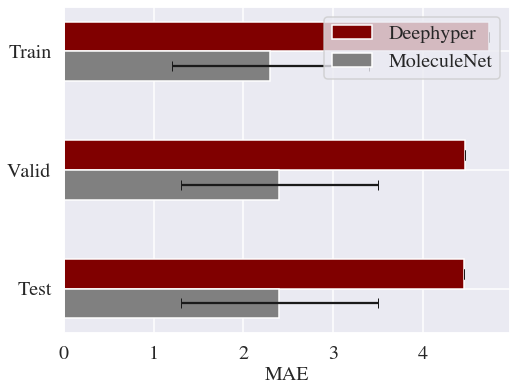

In [19]:
mol_vs_deep(QM9_DATA_DIR, QM9_PLOT_DIR, [2.3, 2.4, 2.4], [1.1, 1.1, 1.1], metric='MAE')

In [16]:
three_random_mean_std(QM9_DATA_DIR, multi_class=True)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.6336+/-0.0000  0.8675+/-0.0000  0.6294+/-0.0000
Valid  0.6395+/-0.0000  0.8664+/-0.0000  0.6294+/-0.0000
Test   0.6405+/-0.0000  0.8780+/-0.0000  0.6273+/-0.0000
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.7597+/-0.0000  1.4437+/-0.0000  0.9785+/-0.0000
Valid  0.7076+/-0.0000  1.1269+/-0.0000  0.9825+/-0.0000
Test   0.7224+/-0.0000  1.2458+/-0.0000  0.9816+/-0.0000
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0064+/-0.0000  0.0001+/-0.0000  0.8373+/-0.0000
Valid  0.0063+/-0.0000  0.0001+/-0.0000  0.8431+/-0.0000
Test   0.0063+/-0.0000  0.0001+/-0.0000  0.8479+/-0.0000
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0070+/-0.0000  0.0001+/-0.0000  0.9556+/-0.0000
Valid  0.0067+/-0.0000  0.

(array([0.14124094, 0.13468103, 0.13682376, 0.08486476, 0.04257677,
        0.04301521, 0.9999474 , 0.9999727 , 0.99997279]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.38777878e-17,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]))

In [22]:
three_random_parity_plot(QM9_DATA_DIR, QM9_PLOT_DIR, multi_class=True, plot=False)

In [23]:
three_random_parity_plot(QM9_DATA_DIR, QM9_PLOT_DIR, plot=False)

# ESOL

In [24]:
ESOL_PLOT_DIR = r"/mnt/d/plots/anl/ESOL/"
ESOL_DATA_DIR = r"/mnt/d/machinelearning2/ANL/ESOL/run_0721/"
ESOL_data = load_json(ESOL_DATA_DIR + 'data_2020-07-24_13.json')

In [25]:
plot_reward_vs_time(ESOL_data, ESOL_PLOT_DIR, ylim=[-0.8, 0], plot=False)
three_random_parity_plot(ESOL_DATA_DIR, ESOL_PLOT_DIR, plot=False)
mol_vs_deep(ESOL_DATA_DIR, ESOL_PLOT_DIR, [0.25, 0.55, 0.58], [0.06, 0.02, 0.03], metric='MSE', plot=False)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.2865+/-0.0236  0.1403+/-0.0256  0.9680+/-0.0059
Valid  0.4673+/-0.0212  0.3945+/-0.0064  0.9153+/-0.0014
Test   0.4015+/-0.0134  0.2867+/-0.0064  0.9310+/-0.0015


## FreeSolv

In [26]:
FreeSolv_PLOT_DIR = r"/mnt/d/plots/anl/FreeSolv/"
FreeSolv_DATA_DIR = r"/mnt/d/machinelearning2/ANL/FreeSolv/run_0721_extra/"
FreeSolv_data = load_json(FreeSolv_DATA_DIR + 'data_2020-07-24_13.json')

In [27]:
plot_reward_vs_time(FreeSolv_data, FreeSolv_PLOT_DIR, ylim=[-1.0, 0], plot=False)
three_random_parity_plot(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, limits=(-15, 5), plot=False)
mol_vs_deep(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, [0.31, 1.20, 1.15], [0.05, 0.02, 0.12], metric='MSE', plot=False)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.4371+/-0.1182  0.4434+/-0.2670  0.9696+/-0.0183
Valid  0.5535+/-0.0081  0.6791+/-0.0263  0.9609+/-0.0015
Test   0.6871+/-0.0485  1.4828+/-0.0079  0.8883+/-0.0006


## Lipophilicity

In [28]:
LIPO_PLOT_DIR = r"/mnt/d/plots/anl/Lipo/"
LIPO_DATA_DIR = r"/mnt/d/machinelearning2/ANL/Lipo/run_0721/"
LIPO_data = load_json(LIPO_DATA_DIR + 'data_2020-07-21_14.json')

In [29]:
plot_reward_vs_time(LIPO_data, LIPO_PLOT_DIR, ylim=[-1.5, None], plot=False)
three_random_parity_plot(LIPO_DATA_DIR, LIPO_PLOT_DIR, plot=False)
mol_vs_deep(LIPO_DATA_DIR, LIPO_PLOT_DIR, [0.471, 0.678, 0.655], [0.001, 0.04, 0.036], metric='MSE', plot=False)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.3871+/-0.0377  0.2572+/-0.0441  0.8185+/-0.0311
Valid  0.4550+/-0.0148  0.3656+/-0.0183  0.7620+/-0.0119
Test   0.4678+/-0.0371  0.3598+/-0.0514  0.7728+/-0.0324


In [30]:
def feature_importance(DATA_DIR, PLOT_DIR):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    X,y = df_new.values[:,0:-1], df_new.values[:,-1]
    X_train = X
    y_train = y
    rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 0)
    rf.fit(X_train, y_train)  
    y_pred = rf.predict(X_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:] 
    features = df_new.columns 
    plt.figure(figsize=(12,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png')
    print(rf.score(X_train, y_train), rf.oob_score_)
    return X, y, features, rf
#     print(df.values[y.argsort()[-10:][::-1],:])

In [269]:
create_csv(ESOL_DATA_DIR, ESOL_data)

In [270]:
train_data = pd.read_csv(ESOL_DATA_DIR + 'nas_result.csv', header=None)
df = train_data
df_new = pd.DataFrame()
for i in range(df.shape[1]):
    if (df.dtypes[i] == 'object'):
        vals = pd.get_dummies(df.iloc[:,i])
    else:
        vals = df.iloc[:,i]
    df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
X = df_new.iloc[:, :-1]
y = df_new.iloc[:, -1]

In [271]:
import lime
import lime.lime_tabular
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = scaler.fit_transform(y.values[..., np.newaxis]).squeeze()
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X.values, y, train_size=0.80, random_state=0)

In [272]:
from sklearn.ensemble import RandomForestRegressor as a
from sklearn.tree import DecisionTreeRegressor as b

In [273]:
reg = a(n_estimators=100, random_state=0).fit(X.values, y)

In [274]:
train = X.values

In [275]:
from treeinterpreter import treeinterpreter as ti

In [276]:
instances = train
prediction, bias, contributions = ti.predict(reg, instances)

In [277]:
mask = np.copy(train)
mask = mask.astype(float)
mask[mask==0] = -1
mask.shape
importance = np.multiply(contributions, mask)

In [278]:
importance2 = importance.mean(axis=0)

In [279]:
importance = np.divide(importance2, train.mean(axis=0))

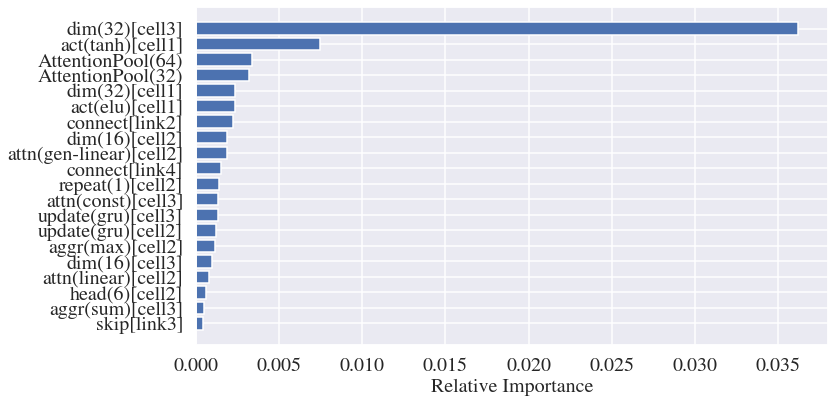

In [280]:
indices = np.argsort(importance)[-20:] 
plt.figure(figsize=(12,6))
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

In [207]:
np.argmax(y)

159

In [7]:
import json
with open(QM8_DATA_DIR + 'best_archs.json', 'r') as f:
    data = json.load(f)

In [8]:
from qm8.qm8.problem import Problem
import tensorflow.keras.backend as K

In [9]:
for i in range(10):
    ops = data['arch_seq'][i]
    reward = data['rewards'][i]
    search_space = Problem.space['create_search_space']['func']()
    search_space.set_ops(ops)
    model = search_space.create_model()
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    print(f'{i}: {trainable_count} {reward}')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0: 181520 -0.31899183988571167
1: 179960 -0.3238743245601654
2: 211536 -0.3245002031326294
3: 187632 -0.32491180300712585
4: 198000 -0.32495933771133423
5: 180176 -0.3251728415489197
6: 181384 -0.32617485523223877
7: 189248 -0.32624077796936035
8: 188576 -0.3264380395412445
9: 179512 -0.32649683952331543


In [76]:
a = [12582,1,10199,1,1,7828,1,0,1,9]

In [77]:
state_dims = ['dim(4)', 'dim(8)', 'dim(16)', 'dim(32)']
Ts = ['repeat(1)', 'repeat(2)', 'repeat(3)', 'repeat(4)']
attn_methods = ['attn(const)', 'attn(gcn)', 'attn(gat)', 'attn(sym-gat)', 'attn(linear)', 'attn(gen-linear)', 'attn(cos)']
attn_heads = ['head(1)', 'head(2)', 'head(4)', 'head(6)']
aggr_methods = ['aggr(max)', 'aggr(mean)', 'aggr(sum)']
update_methods = ['update(gru)', 'update(mlp)']
activations = ['act(sigmoid)', 'act(tanh)', 'act(relu)', 'act(linear)', 'act(elu)', 'act(softplus)', 'act(leaky_relu)', 'act(relu6)']

out = []
for state_dim in state_dims:
    for T in Ts:
        for attn_method in attn_methods:
            for attn_head in attn_heads:
                for aggr_method in aggr_methods:
                    for update_method in update_methods:
                        for activation in activations:
                            out.append([state_dim, T, attn_method, attn_head, aggr_method, update_method, activation])

out_pool = []
for functions in ['GlobalSumPool', 'GlobalMaxPool', 'GlobalAvgPool']:
    for axis in ['(feature)', '(node)']:  # Pool in terms of nodes or features
        out_pool.append(functions+axis)
out_pool.append('flatten')
for state_dim in [16, 32, 64]:
    out_pool.append(f'AttentionPool({state_dim})')
out_pool.append('AttentionSumPool')

out_connect = ['skip', 'connect']

def get_gat(index):
    return out[index]
def get_pool(index):
    return out_pool[index]
def get_connect(index):
    return out_connect[index]


temp = a
b0 = [get_gat(temp[0])[i]+'[cell1]' for i in range(len(get_gat(temp[0])))]
b1 = [get_connect(temp[1])+'[link1]']
b2 = [get_gat(temp[2])[i]+'[cell2]' for i in range(len(get_gat(temp[2])))]
b3 = [get_connect(temp[3])+'[link2]']
b4 = [get_connect(temp[4])+'[link3]']
b5 = [get_gat(temp[5])[i]+'[cell3]' for i in range(len(get_gat(temp[5])))]
b6 = [get_connect(temp[6])+'[link4]']
b7 = [get_connect(temp[7])+'[link5]']
b8 = [get_connect(temp[8])+'[link6]']
b9 = [get_pool(temp[9])]
bout = b0+b1+b2+b3+b4+b5+b6+b7+b8+b9
bout = np.array(bout, dtype=object)
bout

array(['dim(16)[cell1]', 'repeat(2)[cell1]', 'attn(gat)[cell1]',
       'head(4)[cell1]', 'aggr(max)[cell1]', 'update(gru)[cell1]',
       'act(leaky_relu)[cell1]', 'connect[link1]', 'dim(8)[cell2]',
       'repeat(4)[cell2]', 'attn(linear)[cell2]', 'head(1)[cell2]',
       'aggr(mean)[cell2]', 'update(gru)[cell2]', 'act(relu6)[cell2]',
       'connect[link2]', 'connect[link3]', 'dim(8)[cell3]',
       'repeat(2)[cell3]', 'attn(gen-linear)[cell3]', 'head(6)[cell3]',
       'aggr(max)[cell3]', 'update(gru)[cell3]', 'act(elu)[cell3]',
       'connect[link4]', 'skip[link5]', 'connect[link6]',
       'AttentionPool(64)'], dtype=object)